In [1]:
import sys
sys.path.append("../pymodule")

import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('./BTC-M.csv',parse_dates=[0], index_col=[0])
df.drop('value',axis=1, inplace=True)
df.head(3)

,open,high,low,close,volume
2018-09-19 23:50:00,7180000.0,7187000.0,7180000.0,7187000.0,0.504830
2018-09-19 23:51:00,7186000.0,7188000.0,7181000.0,7181000.0,0.882076
2018-09-19 23:52:00,7184000.0,7188000.0,7183000.0,7188000.0,0.486359


In [1]:
import ctypes

def pred_per(df, per, ohlc=True):
    y=np.zeros(len(df), dtype=np.int32)
    y=np.ctypeslib.as_ctypes(y)
    hlud=df[['high','low']]
    hlud['up']=df.close * (1+per)
    hlud['down']=df.close * (1-per)
    x=hlud.to_numpy(dtype=np.int32, copy=True).flatten()
    x=x.ctypes.data_as(ctypes.POINTER(ctypes.c_long))
    d_len=ctypes.c_int(len(df))
    _dll=ctypes.WinDLL("./Dll2.dll")
    _dll.pred_period(d_len,x,y)
    y=np.ctypeslib.as_array(y)
    return y
pred_per(df, 0.0025)

# import pickle
# with open("pred025.pkl", "rb") as fp:
#     pred = pickle.load(fp)

In [2]:
pred

array([ 116,   37, -205, ...,    0,    0,    0], dtype=int32)

In [4]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
import indicators as idc
from torch.utils.data import Dataset

class CDataset(Dataset):
    def __init__(self, df, y, seq_length):
        super(CDataset, self).__init__()
        self.s_len = seq_length
        df_T = idc.resample_T(df, '1T')
    ### x data
        df_T['RSI'] = idc.RSI(df_T,14).values / 100
        df_T['BB'], df_T['BP'] = idc.BB(df_T,20)
        df_T['MACD'], _ = idc.MACD(df_T)
        df_T['dis'] = idc.disparity(df_T, 20)
        df_T['volume'] = (df_T['volume'] - df_T['volume'].mean()) / df_T['volume'].std()

        df_T['EMA5'] = idc.EMA(df_T,5)
        df_T['EMA30'] = idc.EMA(df_T,30)
        df_T['EMA60'] = idc.EMA(df_T,60)
        df_T['EMA90'] = idc.EMA(df_T,90)
        
        df_c = df_T['close'].shift()
        for i in ['open','high','low','close']:
            df_T[i] = (df_T[i] - df_c) / df_c
            df_T[i] = df_T[i] / df_T[i].abs().max()
        
        df_T['BB'] = df_T['BB'] / df_T['BB'].max()
        for i in ['BP', 'MACD', 'dis']:
            df_T[i] = (df_T[i] - df_T[i].min()) / df_T[i].max()
                       
        self.x = torch.FloatTensor(df_T[60:-80].T.values).to(device)
        self.len = len(self.x[0])-self.s_len

    ### y data
        self.y = np.array(y[60:-80], dtype=float)
        self.y = np.where(self.y <= -48, 0.5, self.y)
        self.y = np.where(self.y < 0, 0, self.y)
        self.y = np.where(self.y >32,0.5,self.y)
        self.y = np.where(self.y>0.5, 1,self.y)
        
        self.y = torch.FloatTensor(self.y.T).to(device)

    def __getitem__(self, index):
        self.x_data = self.x[:, index:index+self.s_len]
        self.x_data[-4:] -= self.x_data[-4:].min()
        self.x_data[-4:] /= self.x_data[-4:].max()
        self.x_data = torch.nan_to_num(self.x_data)
        self.y_data = self.y[index+self.s_len]
        return self.x_data, self.y_data
    
    def __len__(self):
        return self.len
    
dataset = CDataset(df, pred, 64)
len(dataset)

2029734

In [6]:
from torch.utils.data import DataLoader, Subset
test_size = 131072
train_set = Subset(dataset, range(len(dataset)-test_size))
test_set = Subset(dataset, range(len(dataset)-test_size, len(dataset)))

train_dloader = DataLoader(train_set, batch_size=256, shuffle=False, drop_last=True)
test_dloader = DataLoader(test_set, batch_size=128, shuffle=False, drop_last=True)

In [7]:
train_features, train_labels = next(iter(train_dloader))
train_features.shape

torch.Size([256, 14, 64])

In [8]:
import torch.nn as nn
import torch.optim as optim

class SCI_Block(nn.Module):
    def __init__(self, features, hidden, dropout=0.5):
        super(SCI_Block,self).__init__()
        self.dropout = dropout
        self.pad = nn.ReplicationPad1d((1,0))
        self.phi = nn.Sequential(
            nn.ReplicationPad1d((5,1)),
            nn.Conv1d(features, hidden, kernel_size=4,dilation=1, stride=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(hidden, features, kernel_size=4),
            nn.Tanh()
        )
        self.psi = nn.Sequential(
            nn.ReplicationPad1d((5,1)),
            nn.Conv1d(features, hidden, kernel_size=5,dilation=1, stride=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(hidden, features, kernel_size=3),
            nn.Tanh()
        )
        self.U   = nn.Sequential(
            nn.ReplicationPad1d((5,1)),
            nn.Conv1d(features, hidden, kernel_size=5,dilation=1, stride=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(hidden, features, kernel_size=3),
            nn.Tanh()
        )
        self.P   = nn.Sequential(
            nn.ReplicationPad1d((5,1)),
            nn.Conv1d(features, hidden, kernel_size=5,dilation=1, stride=1),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.Dropout(self.dropout),
            nn.Conv1d(hidden, features, kernel_size=3),
            nn.Tanh()
        )
    
    def forward(self, F):
        if F.size()[2] %2 == 1:
            F = self.pad(F)
        Fe = F[:, :,  ::2]
        Fo = F[:, :, 1::2]
        d = Fo.mul(torch.exp(self.phi(Fe)))
        c = Fe.mul(torch.exp(self.psi(Fo)))
        
        Fe = c + self.U(d)
        Fo = d - self.P(c)
        
        return Fo, Fe
    

class SCINet(nn.Module):
    def __init__(self, L, features, hidden):
        super(SCINet, self).__init__()
        self.num_layer = 2**L-1
        self.L = L
        self.layers = nn.ModuleList(
            [SCI_Block(features, hidden) for i in range(self.num_layer)])
        
    def forward(self, x):
        results = [x]
        for i in range(self.num_layer):
            seq = results.pop(0)
            Fo, Fe = self.layers[i](seq)
            results.append(Fo)
            results.append(Fe)
        
        interval = 2**(self.L-1)
        while True:
            res = []
            for i in range(interval):
                res.append(torch.cat((results[i], results[i+interval]),2))
            
            results = res
            if interval == 1:
                break
            else:
                interval = interval//2
        x = x + results[0]
        return x
    
class SCINet_stack(nn.Module):
    def __init__(self, stacks, layers, features, hidden=16):
        super(SCINet_stack, self).__init__()
        self.layers = nn.ModuleList(
            [SCINet(layers,features,hidden) for i in range(stacks)])
        self.fc1 = nn.Linear(64,16)
        self.fc2 = nn.Linear(16*features,64)
        self.fc3 = nn.Linear(64,16)
        self.fc4 = nn.Linear(16,1)
    
    def forward(self, x):
        for i in self.layers:
            x = i(x)
        x = self.fc1(x)
        x = self.fc2(x.flatten(1))
        x = self.fc3(x)
        x = self.fc4(x)
        return x

model = SCINet_stack(2,6,14, hidden=16).to(device)
l = model(train_features)
print(l.size(), train_labels.size())
optimizer = optim.AdamW(model.parameters(), lr = 1e-3)
criterion = nn.MSELoss()

torch.Size([256, 1]) torch.Size([256])


In [10]:
import pickle

losses =[]
val_losses=[]
path = "./SCINp.pt"
with open("scinv_train01.pkl", "rb") as fp:
    losses = pickle.load(fp)
with open("scinv_test01.pkl", "rb") as fp:
    val_losses = pickle.load(fp)
model.load_state_dict(torch.load(path))
model.to(device)

SCINet_stack(
  (layers): ModuleList(
    (0): SCINet(
      (layers): ModuleList(
        (0): SCI_Block(
          (pad): ReplicationPad1d((1, 0))
          (phi): Sequential(
            (0): ReplicationPad1d((5, 1))
            (1): Conv1d(14, 16, kernel_size=(4,), stride=(1,))
            (2): LeakyReLU(negative_slope=0.01, inplace=True)
            (3): Dropout(p=0.5, inplace=False)
            (4): Conv1d(16, 14, kernel_size=(4,), stride=(1,))
            (5): Tanh()
          )
          (psi): Sequential(
            (0): ReplicationPad1d((5, 1))
            (1): Conv1d(14, 16, kernel_size=(5,), stride=(1,))
            (2): LeakyReLU(negative_slope=0.01, inplace=True)
            (3): Dropout(p=0.5, inplace=False)
            (4): Conv1d(16, 14, kernel_size=(3,), stride=(1,))
            (5): Tanh()
          )
          (U): Sequential(
            (0): ReplicationPad1d((5, 1))
            (1): Conv1d(14, 16, kernel_size=(5,), stride=(1,))
            (2): LeakyReLU(negative

In [12]:
from models import fit

path = "./SCINp40.pt"

start=time.time()
for epoch in range(10):
    epoch_loss = fit(epoch,model,train_dloader, criterion, optimizer, phase = 'train')
    losses.append(epoch_loss)
    val_epoch_loss = fit(epoch, model, test_dloader, criterion, optimizer, phase ='valid')
    val_losses.append(val_epoch_loss)
    print("{:0,.2f}분".format((time.time()-start)/60))
torch.save(model.state_dict(), path)

epoch:1, trainloss is 0.0007121412413808914
epoch:1, validloss is 0.0015938046234144077
93.08분
epoch:2, trainloss is 0.0007125689048163818
epoch:2, validloss is 0.0015915917067441665
186.18분
epoch:3, trainloss is 0.0007123167407471204
epoch:3, validloss is 0.0015931189568688109
279.37분
epoch:4, trainloss is 0.0007124539124085257
epoch:4, validloss is 0.001592253343225103
372.49분
epoch:5, trainloss is 0.0007123587773229933
epoch:5, validloss is 0.0015914222933488542
465.68분
epoch:6, trainloss is 0.0007125934167625125
epoch:6, validloss is 0.0015928628844990023
558.83분
epoch:7, trainloss is 0.0007132337252664412
epoch:7, validloss is 0.001593265748265793
651.98분
epoch:8, trainloss is 0.0007129506323783761
epoch:8, validloss is 0.0015925358288750857
745.33분


KeyboardInterrupt: 

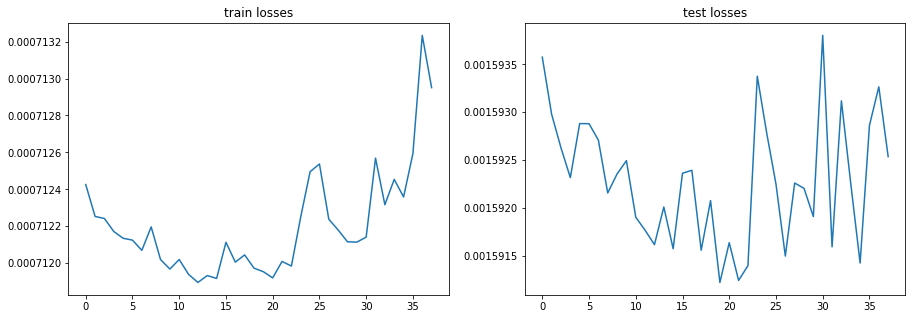

In [13]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(losses[10:]) 
ax[0].set_title('train losses')

ax[1].plot(val_losses[10:])
ax[1].set_title('test losses')
plt.show()

In [ ]:
import pickle
with open("scinv_train01.pkl", "wb") as fp:
    pickle.dump(losses[:],fp)
with open("scinv_test01.pkl", "wb") as fp:
    pickle.dump(val_losses[:], fp)

In [ ]:
model.eval()
x = train_features[[0]]
torch_out = model(x)

torch.onnx.export(model, x, "SCINp.onnx", 
                  export_params=True,                   
                  opset_version=10,
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes={'input' : {0 : 'batch_size'}, 
                                'output' : {0 : 'batch_size'}})